<a href="https://colab.research.google.com/github/kishanp228/Deep-Learning-Projects/blob/main/ImgCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = '/content/drive/MyDrive/FLICKR8K/flickr8k_data'
WORKING_DIR = '/content/drive/MyDrive/FLICKR8K'


In [4]:

# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# extract features from image

In [5]:

features = {}
directory = os.path.join(BASE_DIR, '/content/drive/MyDrive/FLICKR8K/flickr8k_data/Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8095 [00:00<?, ?it/s]

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load the Captions Data

In [8]:
with open(os.path.join(BASE_DIR, '/content/drive/MyDrive/FLICKR8K/flickr8k_data/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

# Preprocess Text Data

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:

# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

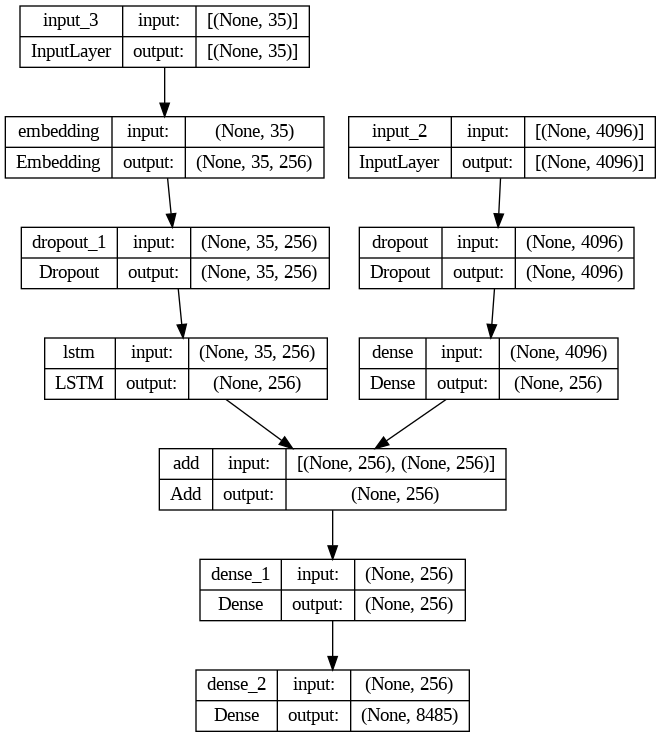

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

# Train the model

In [ ]:

epochs=350
batch_size=128
steps=len(train)//batch_size


generator=data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
history= model.fit(generator,epochs=epochs,steps_per_epoch=steps,verbose=1 )
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Epoch 1/350
56/56 [==============================] - 63s 879ms/step - loss: 5.9703
Epoch 2/350
56/56 [==============================] - 49s 874ms/step - loss: 5.0696
Epoch 3/350
56/56 [==============================] - 49s 880ms/step - loss: 4.4944
Epoch 4/350
56/56 [==============================] - 49s 875ms/step - loss: 3.9914
Epoch 5/350
56/56 [==============================] - 48s 857ms/step - loss: 3.6923
Epoch 6/350
56/56 [==============================] - 49s 877ms/step - loss: 3.4855
Epoch 7/350
56/56 [==============================] - 49s 863ms/step - loss: 3.3292
Epoch 8/350
56/56 [==============================] - 48s 860ms/step - loss: 3.1945
Epoch 9/350
56/56 [==============================] - 48s 863ms/step - loss: 3.0907
Epoch 10/350
56/56 [==============================] - 48s 849ms/step - loss: 2.9993
Epoch 11/350
56/56 [==============================] - 48s 854ms/step - loss: 2.9229
Epoch 12/350
56/56 [==============================] - 48s 861ms/step - loss: 2.8512
E

In [ ]:
# Save the model in native Keras format
model.save(WORKING_DIR + '/best_model.keras')


#Load the model

In [27]:
import tensorflow as tf
model = tf.keras.models.load_model(WORKING_DIR+'/best_model.keras')


In [ ]:
from keras.models import load_model

# Load the model
loaded_model = load_model(WORKING_DIR + '/best_model.h5')

# Evaluate the model
train_loss = loaded_model.evaluate(generator, steps=steps, verbose=0)

# Print training loss
print(f"Training Loss: {train_loss}")


Training Loss: [0.7909632325172424, 0.7617257833480835]


# Training accuracy

In [ ]:
# Compile the model with accuracy as a metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Evaluate the model
evaluation_results = model.evaluate(generator, steps=steps, verbose=0)

# Extract training accuracy from the evaluation results
train_accuracy = evaluation_results[1]  # Assuming accuracy is the second metric in the list

# Print training accuracy
print(f"Training Accuracy: {train_accuracy}")



Training Accuracy: 0.7617182731628418


# Generate Captions for the Image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.496846
BLEU-2: 0.274139


#Visualize the Results

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    #image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "/content/drive/MyDrive/FLICKR8K/flickr8k_data/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq little girl in pink dress going into wooden cabin endseq


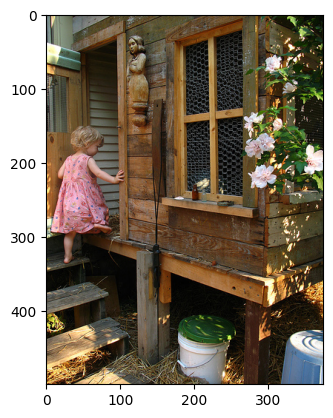

In [32]:
generate_caption("1000268201_693b08cb0e.jpg")

#Test with Real Image

In [33]:
import IPython.display as display
from ipywidgets import FileUpload, Image, Output
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image as PILImage
import io

# Load the VGG16 model
vgg16_model = tf.keras.applications.VGG16()
vgg16_model = tf.keras.Model(inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)

# Load the model
model = tf.keras.models.load_model(WORKING_DIR+'/best_model.h5')

# Function to predict caption for a new image
def generate_caption(image_feature, tokenizer, max_length):
    # Start the caption with the "startseq" token
    in_text = 'startseq'

    # Iterate over the max length of the sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predict next word
        yhat = model.predict([image_feature, sequence], verbose=0)
        # Get index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append word as input for generating the next word
        in_text += " " + word
        # Stop if we reach the endseq tag
        if word == 'endseq':
            break

    return in_text

# Function to handle file upload and display prediction
def handle_upload(change):
    with output_widget:
        # Clear the previous output
        output_widget.clear_output()

        # Get the uploaded image
        uploaded_image = list(file_upload.value.values())[0]['content']
        new_img = PILImage.open(io.BytesIO(uploaded_image))

        # Resize the image to (224, 224) for VGG16 model
        new_img = new_img.resize((224, 224))
        # Convert image pixels to a numpy array
        new_img_array = image.img_to_array(new_img)
        # Reshape data for the VGG16 model
        new_img_array = new_img_array.reshape((1, new_img_array.shape[0], new_img_array.shape[1], new_img_array.shape[2]))
        # Preprocess image for VGG
        new_img_array = tf.keras.applications.vgg16.preprocess_input(new_img_array)

        # Extract features using the VGG16 model
        new_image_feature = vgg16_model.predict(new_img_array, verbose=0)

        # Predict the caption
        predicted_caption = generate_caption(new_image_feature, tokenizer, max_length)

        # Display the result
        display.display(new_img)
        print("Predicted Caption:", predicted_caption)

# Create an output widget for displaying the prediction
output_widget = Output()

# Create a file upload widget
file_upload = FileUpload(accept='.jpg', multiple=False)
file_upload.observe(handle_upload, names='value')

# Display the widgets
display.display(file_upload, output_widget)


FileUpload(value={}, accept='.jpg', description='Upload')

Output()